In [1]:
import rospy
from robotics_demo.msg import JointPositions, Observation, AchievedGoal, PositionCommand, RPYProprioState, Velocities, ResetInfo, Reengage
from robotics_demo.srv import getIK, getIKResponse, getState, getStateResponse
import time

In [2]:
import numpy as np
import os, inspect
import matplotlib.pyplot as plt
AVG_MODEL_PROCESSING_TIME = 0.033
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
print("current_dir=" + currentdir)
os.sys.path.insert(0, currentdir)
from utils import rosImg_to_numpy, proprio_quat_to_rpy_vector, \
        proprio_rpy_to_ROSmsg, ag_to_vector, ag_to_ROSmsg,\
        proprio_rpy_to_rpy_vector, unstack, act_to_jointPositionsROSmsg

current_dir=/catkin_ws/src/unity_robotics_env/robotics_demo/scripts


In [3]:
# The publisher which sends out position commands that then get converted to joint commands by the IK node
pos_cmd_pub = rospy.Publisher('xyz_rpy_g_command', PositionCommand, queue_size=1)
# The publisher which resets the non_arm elements of the state
env_reset_pub = rospy.Publisher('full_reset', ResetInfo, queue_size=1)
env_reEngage_physics_pub = rospy.Publisher('re_engage_physics', Reengage, queue_size=1)
env_reEngage_collision_pub = rospy.Publisher('re_engage_collision', Reengage, queue_size=1)
# service to get IK 
IK = rospy.ServiceProxy('get_IK', getIK)
getStateServ = rospy.ServiceProxy('getState', getState)

In [4]:
# First things first, lets load some data! 
DATA_PATH = os.getcwd()[:-(len("/robotics_demo/scripts"))]+'/data/UR5_train/'
OBS_ACT_PATH = DATA_PATH+'obs_act_etc/'
IMS_PATH = DATA_PATH+'states_and_ims/'
TIME_FREQUENCY = 15
default_vr_controller_pos =  RPYProprioState(-0.4, 0.2, 0.0,0.0,0.0,0.0,0.0)
os.listdir(OBS_ACT_PATH)

['0',
 '1',
 '10',
 '11',
 '12',
 '13',
 '14',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9']

In [5]:
rospy.init_node('jupyter')

In [6]:

    
def process_observation():
    '''
    The full state will be sent out at Nh > controlHz by the env, listen to it, and save the relevant parts
    '''

    o = getStateServ(int(1)).state
    proprioceptive_state  = proprio_quat_to_rpy_vector(o.proprio)
    achieved_goal = ag_to_vector(o.ag)
    full_state = np.concatenate([proprioceptive_state, achieved_goal])
    # process the images
    shoulder_image  = rosImg_to_numpy(o.shoulderImage)
    gripper_image = rosImg_to_numpy(o.gripperImage)
    return proprioceptive_state, achieved_goal, shoulder_image, gripper_image


def check_reset_convergence(proprio, ag, current_proprio, current_ag, threshold = 0.01):
    proprio_checks = abs(proprio - current_proprio) < threshold
    ag_checks = abs(ag-current_ag) < threshold
    all_checks = np.concatenate([proprio_checks, ag_checks])
    return all_checks
#     if np.all(all_checks):
#         return True
#     else:
#         return False
    
def converge_on_reset(proprio, ag, threshold = 0.05):
    t_start = time.time()
    r = rospy.Rate(10) # 10hz 
    while not rospy.is_shutdown():
        t = time.time()
        current_arm, current_ag, _,_ = process_observation()
        checks = check_reset_convergence(proprio, ag, current_arm, current_ag, threshold)
        if (t > t_start+1):
            idxs = np.where(checks == False)
#             print(idxs, proprio[idxs], current_arm[idxs])
            return
        elif np.all(checks):
            return
        r.sleep() # ros sleep for a little while before checking convergence again
    

In [7]:
collected = 0
for i in os.listdir(OBS_ACT_PATH):
    test = np.load(f"{OBS_ACT_PATH}/{int(i)}/data.npz", allow_pickle=True)
    obs, acts, ags, times = test['obs'], test['acts'], test['achieved_goals'], test['times']
    collected += len(obs)
    print(len(obs), i)
print(collected)

5780 0
2310 1
1643 10
235 11
777 12
3929 13
6446 14
349 2
2129 3
2363 4
2746 5
3192 6
3620 7
1838 8
2908 9
40265


In [8]:


def reset_to(arm, ag, prev_act = np.zeros(7)):
    
    arm_msg = proprio_rpy_to_ROSmsg(arm)
    prev_act = act_to_jointPositionsROSmsg(prev_act)
    # Get IK for actual position
    prev_act = JointPositions()
    
    
    # Package into ResetInfo
    for i in range(0,2):
        joints = IK(arm_msg, prev_act).joints # once to align it with the prev acts
        r = ResetInfo(joints, ag_to_ROSmsg(ag), Velocities())
        # Send down
        env_reset_pub.publish(r)
    converge_on_reset(arm, ag, threshold = 0.05)
    env_reEngage_collision_pub.publish(Reengage())
    time.sleep(1/TIME_FREQUENCY)
    
    

In [39]:
test = np.load(f"{OBS_ACT_PATH}/4/data.npz", allow_pickle=True)
obs, acts, ags, times = test['obs'], test['acts'], test['achieved_goals'], test['times']
proprio = obs[:, :7]
print(len(acts))

2363


In [42]:
i = 0
#p[-1] = 1.0
reset_to(proprio[i,:], ags[i,:])
TIME_FREQUENCY = 15

In [43]:
env_reEngage_physics_pub.publish(Reengage())
t0 = time.time()
next_time = t0 + 1/TIME_FREQUENCY
while not rospy.is_shutdown() and i < len(acts):
    t = time.time()
    if t >= next_time:
        # Triggers corelogic acting
        try:
            next_time = next_time + 1/TIME_FREQUENCY
            time.sleep(AVG_MODEL_PROCESSING_TIME)
            pos_cmd_pub.publish(proprio_rpy_to_ROSmsg(acts[i,:]))
            i += 1
        except Exception as e:
            print(e)
            break

KeyboardInterrupt: 

In [33]:
current_arm, current_ag, _,_ = process_observation()
current_arm

array([-4.21386331e-01,  4.97372478e-01,  3.53975385e-01,  1.58290440e-01,
       -1.77553100e-01,  5.35593679e-02,  1.39999393e-04])

In [128]:
for i in range(110, 150):
    print(i)
    reset_to(proprio[i,:], ags[i,:], acts[i,:])

110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


In [29]:
#env_reEngage_pub.publish(Reengage())
r = rospy.Rate(5) # 15hz 
while not rospy.is_shutdown() and i < len(acts):
    try:
        pos_cmd_pub.publish(proprio_rpy_to_ROSmsg(acts[i,:]))
        #env_reset_pub.publish(ag_to_ROSmsg(ags[i,:])) # shape (7,)
        i += 1
        print(i)
    except Exception as e:
        print(e)
        break
    r.sleep() # ros sleep for a little while before checking convergence again

111
112
113
114
115
116
117
118
119
120
121
122
123
124
125


KeyboardInterrupt: 

In [21]:
import time
for i in range(800, len(proprio)):
    reset_to(proprio[i,:], ags[i,:])
    time.sleep(0.04)

KeyboardInterrupt: 

In [35]:
proprio_rpy_to_ROSmsg(proprio[idx,:])

pos_x: -0.4428572952747345
pos_y: 0.22392550110816956
pos_z: 0.4295077919960022
rot_r: 0.6223673820495605
rot_p: -0.22585928440093994
rot_y: -0.1272006332874298
gripper: 0.9654262661933899

In [37]:
idx = 60
pos_cmd_pub.publish(proprio_rpy_to_ROSmsg(proprio[idx,:]))

In [25]:
times[0]

{'timestep': 9996,
 'data_arrival_time': 1618009958.5699267,
 'data_processed_time': 1618009958.572478,
 'beat_sent_time': 1618009958.5986288,
 'act_begin_time': 1618009958.604449,
 'model_processed_time': 1618009958.637456}

In [30]:
# What we can do is say the beat sent time is the 'centre', thats 0
# then the order should be data_arrival, beat_sent, act_begin, model_processed
# therefore we can create a histogram for each of these around 0
ts, da, dp, ab, mp = [], [], [], [], []

for t in times:
    ts.append(t['timestep'])
    beat = t['beat_sent_time']
    da.append(t['data_arrival_time']- beat)
    #dp.append(t['data_processed_time'] - beat)
    #bs.append(beat)
    ab.append(t['act_begin_time'] - beat)
    mp.append(t['model_processed_time'] - beat)
    
bs = []
for i in range(0,len(times)-1):
    bs.append(times[i+1]['beat_sent_time'] - times[i]['beat_sent_time'])
    


In [31]:
ts = np.array(ts)
ts[1:200]-ts[0:199]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1])

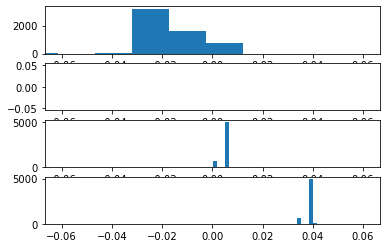

In [32]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(4)
left, right = -1/TIME_FREQUENCY, 1/TIME_FREQUENCY
axs[0].hist(da)
axs[1].hist(dp)
axs[2].hist(ab)
axs[3].hist(mp)

for i in range(0,len(axs)):
    axs[i].set_xlim(left=left, right=right)
    

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 3.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 3.000e+00,
        2.000e+00, 5.000e+00, 1.200e+01, 2.100e+01, 3.100e+01, 5.600e+01,
        9.200e+01, 1.559e+03, 3.744e+03, 9.200e+01, 5.700e+01, 3.300e+01,
        2.300e+01, 1.200e+01, 5.000e+00, 2.000e+00, 3.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 3.000e+00, 1.000e+00, 0.000e+00, 2.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

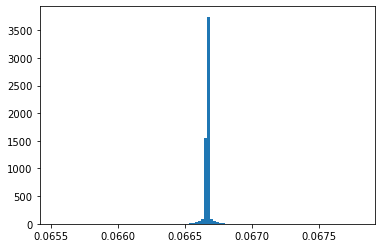

In [33]:
plt.hist(bs, bins=100)

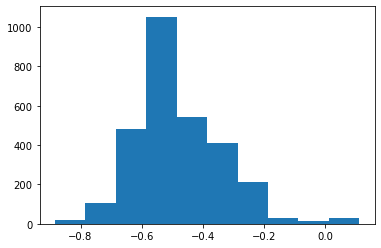

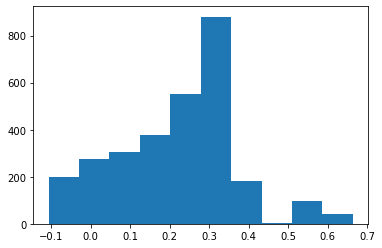

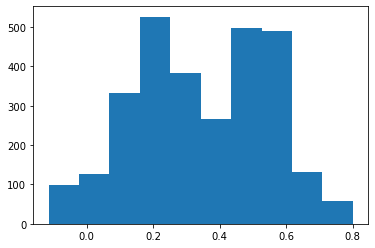

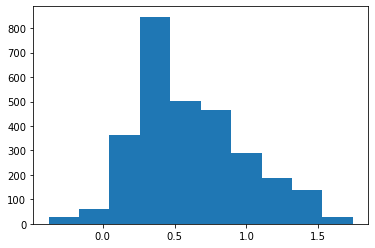

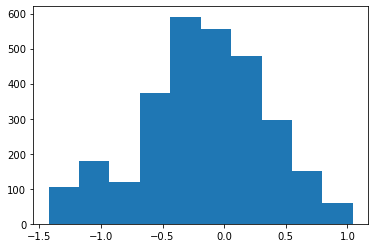

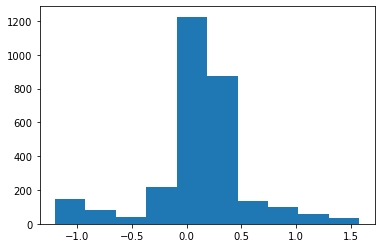

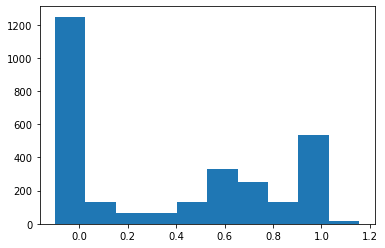

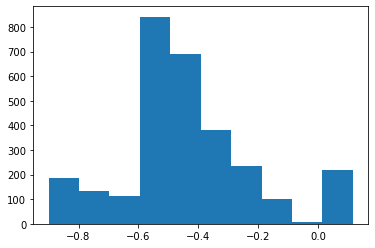

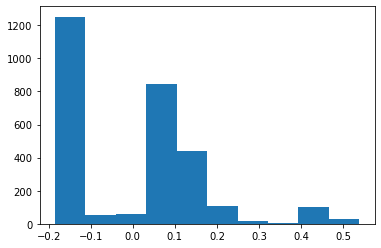

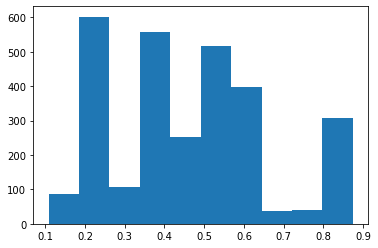

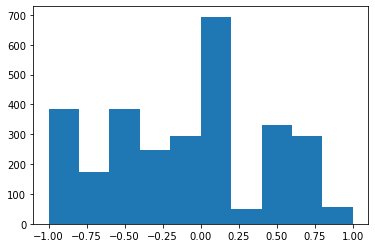

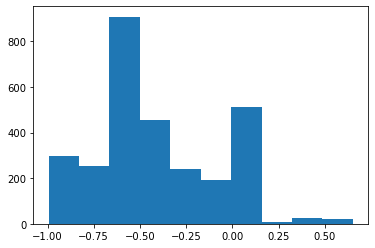

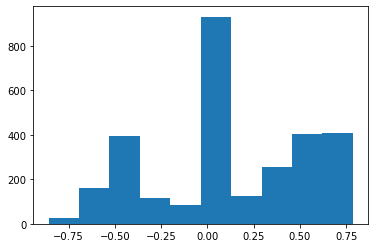

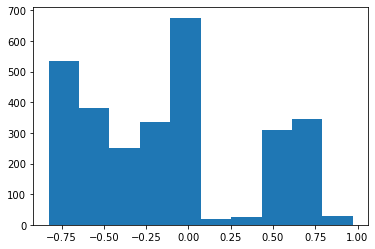

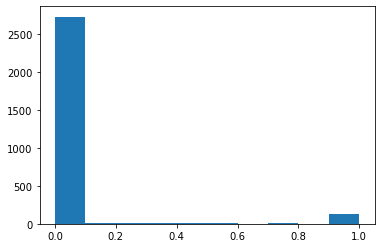

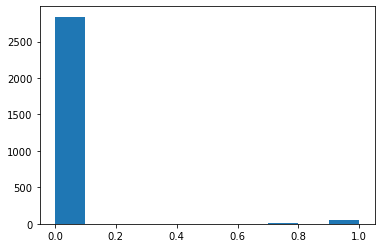

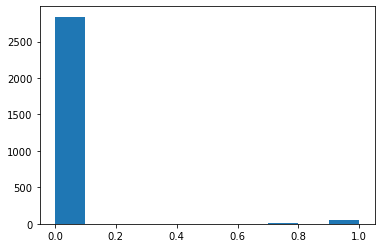

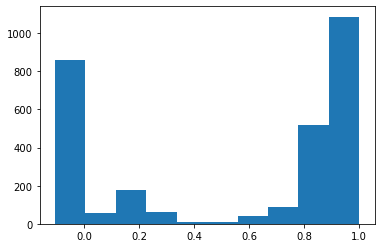

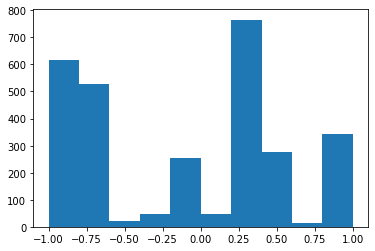

In [9]:
d = obs
for i in range(0, d.shape[1]):
    plt.hist(d[:,i])
    plt.show()

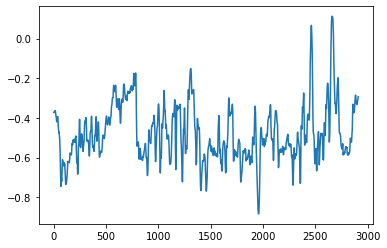

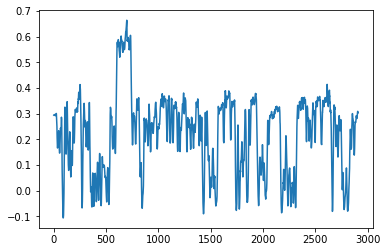

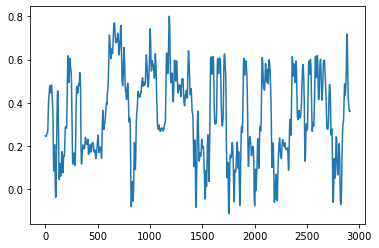

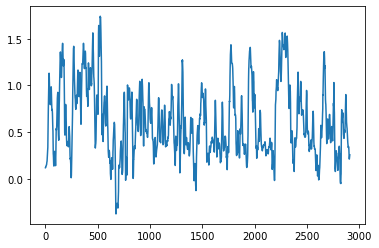

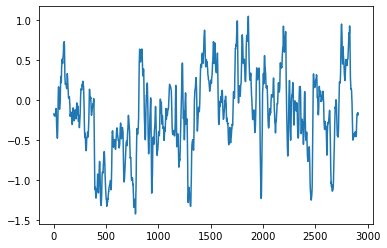

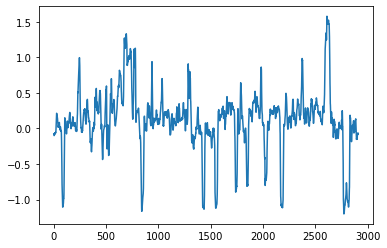

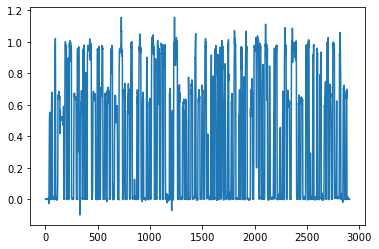

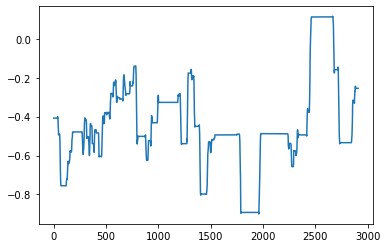

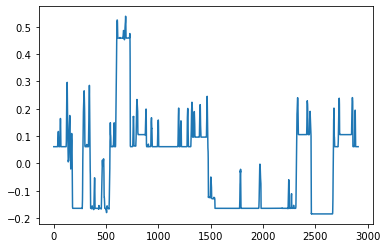

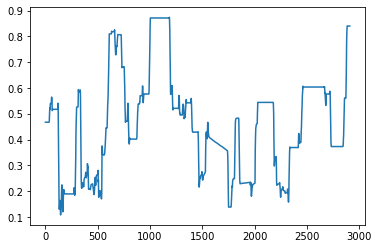

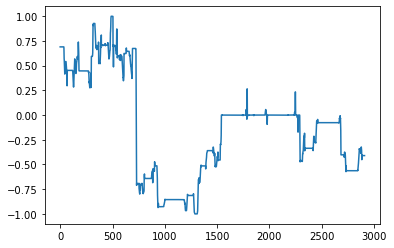

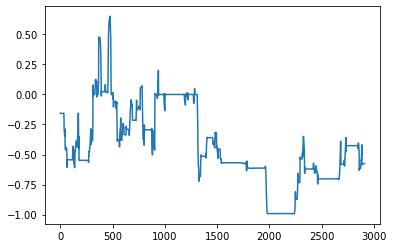

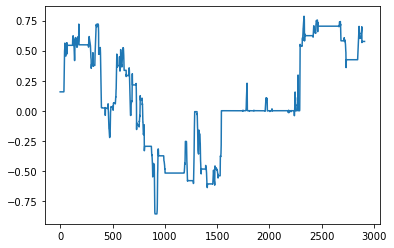

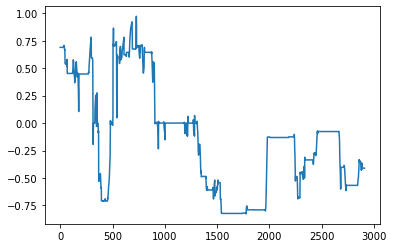

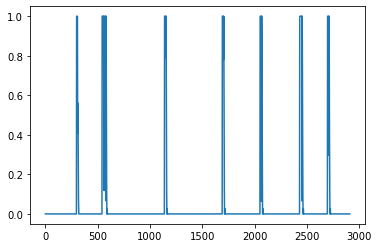

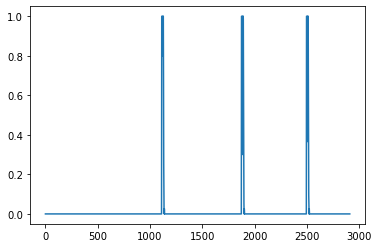

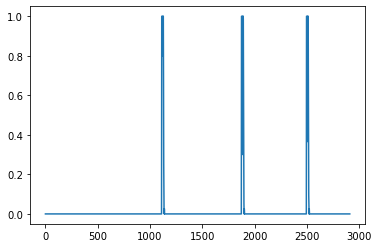

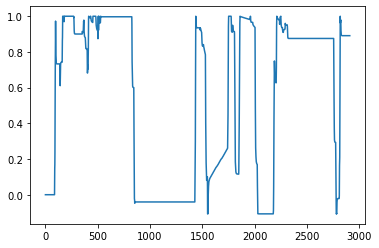

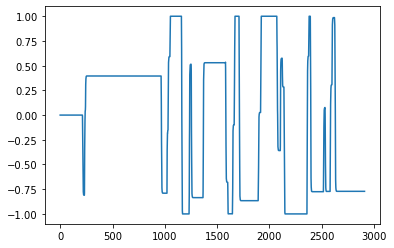

In [10]:
for i in range(0, d.shape[1]):
    plt.plot(np.linspace(0,len(d),len(d)), d[:,i])
    #plt.plot(np.linspace(0,len(acts),len(acts)), acts[:,i])
    plt.show()